In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from vrAnalysis.helpers import errorPlot
from photometry.loaders import get_doric_files, process_data_parallel

from syd import make_viewer

In [2]:
mouse_name = "ATL061"
dirs, findex, data = get_doric_files(mouse_name)
print(f"Found {len(data)} files")

Could not parse file index from D:\localData\ATL061\2024-11-18/ATL061_2024-11-18.doric
Found 16 files


In [3]:
# Get the results from all sessions of the data files
preperiod = 0.2
postperiod = 1.0
results, opto_responses = process_data_parallel(data, preperiod=preperiod, postperiod=postperiod)

Processing files: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


In [4]:
def plot(viewer, state):
    idx_session = state["idx_session"]
    
    res = results[idx_session]

    cmap = plt.get_cmap("cividis")
    colors = np.array([cmap(i/len(results)) for i in range(len(results))])

    fig = plt.figure(figsize=(12, 4), layout="constrained")
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.2, 1.0], wspace=0.1)

    # Plot all sessions
    ax = fig.add_subplot(gs[0])
    for iresponse, response in enumerate(opto_responses):
        ax.plot(res["time_opto_response"], response, color=colors[iresponse] if iresponse != idx_session else "k", zorder=1 if iresponse != idx_session else 1000)
    ax.set_xlim(-preperiod, postperiod/2)
    ax.axhline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Averages")

    # Plot the current session's data in particular
    ax = fig.add_subplot(gs[1])
    errorPlot(res["time_opto"], res["in1_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="black", label="iso")
    errorPlot(res["time_opto"], res["in2_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="green", label="fluor")
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Average")
    ax.set_xlim(-preperiod, 0.8)

    ax_cbar = fig.add_subplot(gs[2])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(results)-1))
    cbar = plt.colorbar(sm, cax=ax_cbar, label='Session #')
    cbar.set_ticks([0, len(results)-1])  # Only show first and last session numbers
    cbar.set_ticklabels(['1', str(len(results))])  # Label them as 1 and max

    # Plot all the data from the selected session
    ax = fig.add_subplot(gs[3])
    relative_data = res["in2_opto"] - res["in1_opto"]
    ax.imshow(relative_data, aspect="auto", cmap="plasma", extent=[-preperiod, postperiod, 0, len(relative_data)])
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--")
    ax.set_xlim(-preperiod, postperiod)
    ax.set_ylim(0, len(relative_data))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Trial #")
    ax.set_title("Session Trials")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("idx_session", value=18, min_value=0, max_value=len(results)-1)
viewer.deploy()

C:\Users\Andrew\Documents\GitHub\syd\syd\parameters.py:676: ParameterUpdateWarning: Warning updating IntegerParameter parameter 'idx_session': Value 18 above maximum 15, clamping
  warn(


C:\Users\Andrew\AppData\Local\Temp\ipykernel_544\1671750821.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4), layout="constrained")


100%|██████████| 22/22 [00:00<00:00, 114.08it/s]


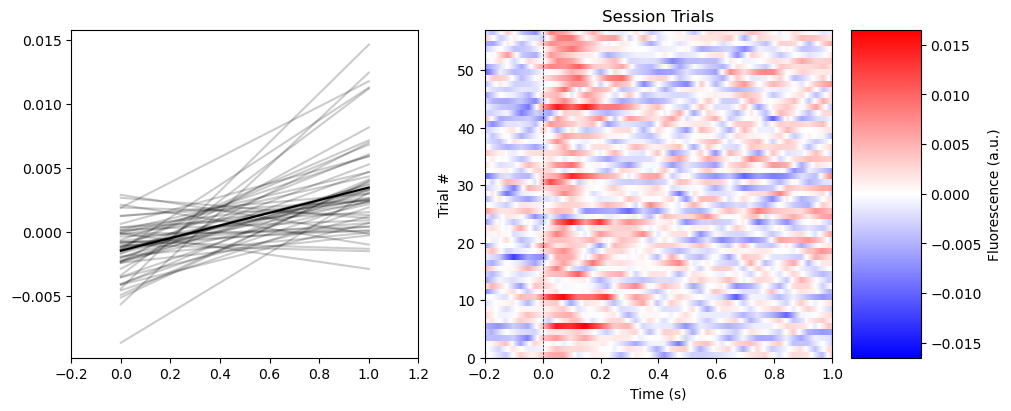

In [75]:
def get_summary(isession):
    res = results[isession]
    relative_data = res["in2_opto"] - res["in1_opto"]
    trial_time = res["time_opto"]

    baseline_window = (-0.15, -0.05)
    peak_window = (0.05, 0.15)
    baseline_idx = np.where((trial_time >= baseline_window[0]) & (trial_time <= baseline_window[1]))[0]
    peak_idx = np.where((trial_time >= peak_window[0]) & (trial_time <= peak_window[1]))[0]

    baseline_mean = np.mean(relative_data[:, baseline_idx], axis=1)
    peak_mean = np.mean(relative_data[:, peak_idx], axis=1)
    
    data_compare = np.stack([baseline_mean, peak_mean], axis=0)
    ttest_result = ttest_rel(peak_mean, baseline_mean)

    # Also measure effect size
    difference = np.mean(peak_mean - baseline_mean)
    average_std = np.mean(np.std(data_compare, axis=1))
    effect_size = difference / average_std
    return data_compare, ttest_result, effect_size

num_sessions = len(results)
data_compare = []
ttest_result = []
effect_size = []
for isession in tqdm(range(num_sessions)):
    summary_results = get_summary(isession)
    data_compare.append(summary_results[0])
    ttest_result.append(summary_results[1])
    effect_size.append(summary_results[2])

cmap = plt.get_cmap("cividis")
colors = np.array([cmap(i/len(results)) for i in range(len(results))])

fig = plt.figure(figsize=(10, 4), layout="constrained")
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.2])
ax = fig.add_subplot(gs[0])
ax.plot([0, 1], data_compare[15], color="black", alpha=0.2)
ax.plot([0, 1], np.mean(data_compare[15], axis=1), color="black", alpha=1)
ax.set_xlim(-0.2, 1.2)

cmap = plt.get_cmap("bwr")
relative_data = results[15]["in2_opto"] - results[15]["in1_opto"]
max_val = np.max(np.abs(relative_data))
ax = fig.add_subplot(gs[1])
imdata = ax.imshow(relative_data, aspect="auto", interpolation="none", cmap=cmap, extent=[-preperiod, postperiod, 0, results[15]["in2_opto"].shape[0]], vmin=-max_val, vmax=max_val)
ax.axvline(0, color="black", linewidth=0.5, linestyle="--")
ax.set_xlim(-preperiod, postperiod)
ax.set_ylim(0, results[15]["in2_opto"].shape[0])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_title("Session Trials")

ax = fig.add_subplot(gs[2])
plt.colorbar(imdata, cax=ax, label='Fluorescence (a.u.)')
plt.show()

# fig = plt.figure(figsize=(10, 4), layout="constrained")
# gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.2])

# ax = fig.add_subplot(gs[0])
# deltas = [dc[1] - dc[0] for dc in data_compare]
# max_trials = max([len(d) for d in deltas])
# deltas_nanpad = [np.pad(d, (0, max_trials - len(d)), mode="constant", constant_values=np.nan) for d in deltas]
# deltas = np.stack(deltas_nanpad, axis=0)
# errorPlot(np.arange(len(results)), deltas, axis=1, ax=ax, color="k", alpha=0.2, se=True)
# for i in range(len(results)):
#     ax.plot(i, np.nanmean(deltas[i]), color=colors[i], marker="o", markersize=5)
# ax.set_xlim(-0.5, len(results)-0.5)
# ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
# ax.set_title("Baseline vs Peak")

# ax = fig.add_subplot(gs[1])
# ax.plot(effect_size, color="black")
# for i in range(len(results)):
#     ax.plot(i, effect_size[i], color=colors[i], marker="o", markersize=8)
# ax.set_xlabel("Session #")
# ax.set_ylabel("Effect Size")
# ax.set_title("Effect Size")
# ax.set_ylim(0, 3)

# ax = fig.add_subplot(gs[2])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(results)-1))
# cbar = plt.colorbar(sm, cax=ax, label='Session #')
# cbar.set_ticks([0, len(results)-1])  # Only show first and last session numbers
# cbar.set_ticklabels(['1', str(len(results))])  # Label them as 1 and max
# plt.show()
